In [70]:
#Import Packages
import nltk 
import spacy
import numpy as np
import pandas as pd
import re

import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [71]:
from pprint import pprint

In [72]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [73]:
# NLTK Stop words

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

#stop_words

In [74]:
#Look at the data
df = pd.read_csv('readability_passivity.csv')

#Sample 100 per year
#df = df.drop(columns = ['Unnamed: 0']).dropna(subset=['principal_strategies'])
#df = df.groupby('filing_year').apply(lambda s: s.sample(110)).reset_index(drop=True)

#check
#df.iloc[:,1].value_counts()  #check

df

,Unnamed: 0,Unnamed: 0.1,accession#,filing_year,principal_strategies,Fog_avg,Fog_dist,Ari_avg,Ari_dist,Sent_count_avg,Pass_verb_avg,Pass_sent_avg,Pass_verb_dist,Pass_sent_dist
0,0,1179,0001209286-10-000410,2010,the fund invests at least 80% of its assets in...,18,"[19.71, 14.8, 11.31, 16.91, 10.3, 18.13, 8.2, ...",14,"[13.5, 11.7, 8.1, 17.3, 11.5, 14.6, 6.1, 22.3,...",10,0.183333,0.020000,"[0.0, 0.0, 0.3333333333333333, 0.0, 0.5, 0.0, ...","[0.0, 0.0, 0.1, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, ..."
1,1,439,0000950123-10-063295,2010,"to pursue its goal, the fund primarily invests...",17,"[16.02, 24.13, 19.88, 16.67, 16.55, 20.0, 20.2...",15,"[11.9, 24.1, 16.3, 11.5, 16.8, 20.7, 30.0, 9.3...",29,0.092241,0.013080,"[0.0, 0.0, 0.4, 0.0, 0.0, 0.1, 0.0, 0.4, 0.0, ...","[0.0, 0.0, 0.06896551724137931, 0.0, 0.0, 0.03..."
2,2,735,0000898432-10-001255,2010,"| during normal market conditions, the large c...",22,"[29.75, 20.0, 18.0, 28.27, 22.0, 18.9]",22,"[30.0, 20.7, 17.4, 30.8, 23.5, 13.7]",6,0.055556,0.055556,"[0.0, 0.16666666666666666, 0.0, 0.0, 0.1666666...","[0.0, 0.16666666666666666, 0.0, 0.0, 0.1666666..."
3,3,489,0001104659-10-022919,2010,"under normal market conditions, the portfolio ...",19,"[20.86, 16.02, 16.09, 32.18, 21.07, 17.8, 16.6...",19,"[22.7, 12.4, 14.5, 34.5, 24.5, 21.1, 15.3, 24....",49,0.124927,0.012911,"[0.0, 0.0, 0.3333333333333333, 0.2857142857142...","[0.0, 0.0, 0.02040816326530612, 0.040816326530..."
4,4,233,0001193125-10-081545,2010,"under normal circumstances, the fund invests a...",17,"[21.26, 24.25, 14.11, 15.02, 16.55, 20.86, 18....",16,"[19.9, 23.6, 12.9, 16.9, 16.9, 23.0, 13.3, 11....",9,0.185185,0.061728,"[0.0, 0.16666666666666666, 0.5, 0.0, 0.0, 0.0,...","[0.0, 0.1111111111111111, 0.1111111111111111, ..."
5,5,966,0000932471-10-000123,2010,the fund invests in domestic stocks that span ...,20,"[21.17, 21.37, 20.0]",17,"[17.6, 19.1, 17.0]",3,0.000000,0.000000,"[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]"
6,6,722,0001193125-10-221804,2010,"of the fund under normal market conditions, th...",21,"[12.93, 20.73, 18.05, 22.34, 27.01, 28.75, 22....",22,"[12.1, 23.8, 16.9, 21.8, 26.3, 36.9, 21.9, 23.2]",8,0.198413,0.062500,"[0.0, 0.3333333333333333, 1.0, 0.0, 0.0, 0.111...","[0.0, 0.125, 0.125, 0.0, 0.0, 0.125, 0.0, 0.125]"
7,7,1129,0001193125-10-219651,2010,"under normal market conditions, the fund inves...",15,"[16.16, 13.76, 8.04, 12.44, 16.4, 14.8, 19.33,...",15,"[16.3, 14.6, 10.2, 11.4, 16.0, 10.5, 11.8, 23....",40,0.167708,0.014375,"[0.0, 0.3333333333333333, 1, 0.0, 0.5, 0.0, 0....","[0.0, 0.05, 0.0, 0.0, 0.025, 0.0, 0.0, 0.0, 0...."
8,8,1101,0000950123-10-088218,2010,the fund seeks to achieve its investment objec...,17,"[17.92, 15.49, 17.03, 21.2, 24.0, 17.8, 16.02,...",16,"[13.8, 18.3, 12.1, 19.5, 25.1, 17.6, 13.1, 24....",24,0.099702,0.010417,"[0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.16...","[0.0, 0.0, 0.0, 0.0, 0.041666666666666664, 0.0..."
9,9,725,0001104659-10-050537,2010,"under normal market conditions, the fund inves...",18,"[19.48, 13.92, 13.87, 32.48, 22.18, 18.31, 14....",18,"[21.1, 11.1, 13.2, 35.0, 26.8, 23.0, 14.0, 23....",49,0.134823,0.013328,"[0.0, 0.0, 0.3333333333333333, 0.2857142857142...","[0.0, 0.0, 0.02040816326530612, 0.040816326530..."


In [75]:
df.shape

(1800, 14)

In [76]:
#Text Preprocessing ------------------------------------------------------------------

In [77]:
# Convert to list
data = df.principal_strategies.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['the fund invests at least 80% of its assets in a diversified portfolio of '
 'equity securities of domestic small cap domestic companies. “assets” means '
 'net assets, plus the amount of borrowing for investment purposes. '
 'shareholders will be given 60 days’ advance notice of any change to this '
 'policy. for these purposes, the adviser defines small cap issuers as those '
 'with market capitalizations within the range encompassed by the russell 2000 '
 'index at the time of purchase. as of may 31, 2010, the market capitalization '
 'range of the russell 2000 index was between $112 million and $2.3 billion. '
 'the fund seeks to invest in companies with innovative products and services '
 'or that offer environmental or societal benefits. the fund also may invest '
 'in foreign securities. the walden small cap innovations fund integrates '
 'comprehensive environmental, social and governance (esg) guidelines in '
 'portfolio construction. the fund also seeks to strengthen esg pe

In [78]:
#This gets just the words w/o the stops and the punkt

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

pprint(data_words[:1])

[['the',
  'fund',
  'invests',
  'at',
  'least',
  'of',
  'its',
  'assets',
  'in',
  'diversified',
  'portfolio',
  'of',
  'equity',
  'securities',
  'of',
  'domestic',
  'small',
  'cap',
  'domestic',
  'companies',
  'assets',
  'means',
  'net',
  'assets',
  'plus',
  'the',
  'amount',
  'of',
  'borrowing',
  'for',
  'investment',
  'purposes',
  'shareholders',
  'will',
  'be',
  'given',
  'days',
  'advance',
  'notice',
  'of',
  'any',
  'change',
  'to',
  'this',
  'policy',
  'for',
  'these',
  'purposes',
  'the',
  'adviser',
  'defines',
  'small',
  'cap',
  'issuers',
  'as',
  'those',
  'with',
  'market',
  'capitalizations',
  'within',
  'the',
  'range',
  'encompassed',
  'by',
  'the',
  'russell',
  'index',
  'at',
  'the',
  'time',
  'of',
  'purchase',
  'as',
  'of',
  'may',
  'the',
  'market',
  'capitalization',
  'range',
  'of',
  'the',
  'russell',
  'index',
  'was',
  'between',
  'million',
  'and',
  'billion',
  'the',
  'fund'

In [79]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[50]]])

['to', 'pursue', 'its', 'goal', 'the', 'fund', 'primarily', 'invests', 'in', 'stocks', 'that', 'are', 'included', 'in', 'the', 'ftse', 'rafi', 'us', 'index', 'the', 'index', 'the', 'index', 'is', 'composed', 'of', 'the', 'largest', 'listed', 'companies', 'incorporated', 'in', 'the', 'united_states', 'ranked', 'by', 'four', 'fundamental', 'financial', 'measures', 'of', 'size', 'sales', 'cash', 'flows', 'book', 'value', 'and', 'dividends', 'an', 'overall', 'weight', 'is', 'calculated', 'for', 'each', 'company', 'by', 'equally', 'weighting', 'each', 'fundamental', 'measure', 'each', 'of', 'the', 'companies', 'in', 'the', 'index', 'is', 'assigned', 'weight', 'equal', 'to', 'its', 'fundamental', 'weight', 'the', 'index', 'is', 'rebalanced', 'and', 'reconstituted_annually', 'the', 'index', 'is', 'compiled', 'and', 'calculated', 'by', 'ftse', 'international', 'limited', 'index', 'ownership', 'ftse', 'is', 'trademark', 'of', 'the', 'financial', 'times', 'limited', 'and', 'the', 'london', 'stoc

In [80]:
nlp = spacy.load("en_core_web_sm")

In [93]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
#Apply NLP Pipeline

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

pprint(data_lemmatized[:1])

[['fund',
  'invest',
  'least',
  'asset',
  'diversify',
  'portfolio',
  'equity',
  'security',
  'domestic',
  'small',
  'cap',
  'domestic',
  'company',
  'asset',
  'mean',
  'net',
  'asset',
  'amount',
  'borrowing',
  'investment',
  'purpose',
  'shareholder',
  'give',
  'day',
  'advance',
  'notice',
  'change',
  'policy',
  'purpose',
  'adviser',
  'define',
  'small',
  'cap',
  'issuer',
  'market',
  'capitalization',
  'range',
  'index',
  'time',
  'purchase',
  'market',
  'capitalization',
  'fund',
  'seek',
  'invest',
  'company',
  'innovative_product',
  'service',
  'offer',
  'environmental',
  'societal',
  'benefit',
  'fund',
  'also',
  'invest',
  'foreign',
  'security',
  'walden',
  'small',
  'cap',
  'innovation',
  'fund',
  'integrate',
  'comprehensive',
  'environmental_social',
  'guideline',
  'portfolio',
  'construction',
  'fund',
  'also',
  'seek',
  'strengthen',
  'esg',
  'performance',
  'accountability',
  'portfolio',
  'com

In [65]:
#Text Formatting ------------------------------------------------------------------

In [18]:
#Formatting for Gensim

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 3), (7, 1), (8, 1), (9, 3), (10, 2), (11, 1), (12, 3), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 5), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 3), (33, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 2), (43, 3), (44, 1), (45, 1), (46, 1), (47, 1), (48, 2), (49, 1), (50, 2), (51, 2), (52, 1), (53, 2), (54, 3), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1)]]


In [19]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('accountability', 1),
  ('advance', 1),
  ('adviser', 1),
  ('advocacy', 1),
  ('also', 2),
  ('amount', 1),
  ('asset', 3),
  ('benefit', 1),
  ('borrowing', 1),
  ('cap', 3),
  ('capitalization', 2),
  ('change', 1),
  ('company', 3),
  ('comprehensive', 1),
  ('construction', 1),
  ('day', 1),
  ('define', 1),
  ('diversify', 1),
  ('domestic', 2),
  ('engagement', 1),
  ('environmental', 1),
  ('environmental_social', 1),
  ('equity', 1),
  ('esg', 1),
  ('foreign', 1),
  ('fund', 5),
  ('give', 1),
  ('guideline', 1),
  ('index', 1),
  ('innovation', 1),
  ('innovative_product', 1),
  ('integrate', 1),
  ('invest', 3),
  ('investment', 1),
  ('issuer', 1),
  ('least', 1),
  ('market', 2),
  ('mean', 1),
  ('net', 1),
  ('notice', 1),
  ('offer', 1),
  ('performance', 1),
  ('policy', 2),
  ('portfolio', 3),
  ('principal', 1),
  ('proxy', 1),
  ('public', 1),
  ('purchase', 1),
  ('purpose', 2),
  ('range', 1),
  ('security', 2),
  ('seek', 2),
  ('service', 1),
  ('shareholder

In [20]:
#
#LDA Modeling ------------------------------------------------------------------
#

In [21]:
#10 Topics -----------------------------------------------------------

In [22]:
# Build LDA model
lda_model10 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)

In [23]:
# Print the Keyword in the 10 topics
pprint(lda_model10.print_topics())
doc_lda10 = lda_model10[corpus]

[(0,
  '0.048*"invest" + 0.046*"company" + 0.041*"real" + 0.039*"estate" + '
  '0.025*"industry" + 0.023*"stock" + 0.021*"investment" + 0.020*"asset" + '
  '0.018*"condition" + 0.017*"normally"'),
 (1,
  '0.082*"company" + 0.031*"market" + 0.026*"capitalization" + 0.026*"growth" '
  '+ 0.024*"stock" + 0.024*"fund" + 0.024*"security" + 0.022*"invest" + '
  '0.018*"investment" + 0.018*"value"'),
 (2,
  '0.032*"attributable" + 0.010*"explain" + 0.006*"westpeak" + '
  '0.006*"activebeta" + 0.001*"outline" + 0.001*"contributor" + '
  '0.001*"combined" + 0.001*"layer" + 0.000*"baron" + 0.000*"tranche"'),
 (3,
  '0.000*"diagnostic" + 0.000*"dental" + 0.000*"existence" + '
  '0.000*"uninvested" + 0.000*"pende" + 0.000*"optical" + 0.000*"hospital" + '
  '0.000*"sixty" + 0.000*"wider_margin" + 0.000*"deviations_fall"'),
 (4,
  '0.061*"fund" + 0.025*"market" + 0.020*"short" + 0.017*"risk" + '
  '0.017*"investment" + 0.015*"option" + 0.015*"portfolio" + 0.014*"position" '
  '+ 0.014*"return" + 0.0

In [24]:
# Compute Perplexity
print('\nPerplexity: ', lda_model10.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model10, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

#Coherence Score:  0.4249947108716034  -- 10 topics, 10 passes


Perplexity:  -5.8927757656039725

Coherence Score:  0.40819650606487273


In [25]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model10, corpus, id2word)
vis

C:\Users\peter\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.116723  0.129270       1        1  23.495480
8      0.164603 -0.000895       2        1  18.112104
6      0.136012 -0.157989       3        1  15.362668
4      0.060088 -0.121354       4        1  15.332277
5      0.044916  0.040439       5        1  10.757056
9      0.114726 -0.144936       6        1   8.423669
7      0.088990  0.034196       7        1   4.321342
0     -0.017009  0.308279       8        1   4.179167
2     -0.357472 -0.044127       9        1   0.014885
3     -0.351577 -0.042883      10        1   0.001348, topic_info=     Category          Freq                 Term         Total  loglift  \
43    Default   5369.000000            portfolio   5369.000000  30.0000   
12    Default   9036.000000              company   9036.000000  29.0000   
28    Default   5003.000000                index   5003.000000  28.0000   
554   Default   3454.000000           allocation   3454.000000  27.0000   
25    Default  22824.000000                 fund  22824.000000  26.0000   
50    Default  10384.000000             security  10384.000000  25.0000   
32    Default   8339.000000               invest   8339.000000  24.0000   
435   Default   2948.000000             underlie   2948.000000  23.0000   
2     Default   3379.000000              adviser   3379.000000  22.0000   
544   Default   2405.000000               target   2405.000000  21.0000   
190   Default   5324.000000                stock   5324.000000  20.0000   
33    Default  10260.000000           investment  10260.000000  19.0000   
6     Default   7253.000000                asset   7253.000000  18.0000   
112   Default   2665.000000               growth   2665.000000  17.0000   
22    Default   4892.000000               equity   4892.000000  16.0000   
175   Default    980.000000                 real    980.000000  15.0000   
103   Default   1792.000000             exposure   1792.000000  14.0000   
10    Default   3103.000000       capitalization   3103.000000  13.0000   
183   Default   2190.000000                 risk   2190.000000  12.0000   
99    Default    897.000000               estate    897.000000  11.0000   
121   Default   4063.000000              include   4063.000000  10.0000   
911   Default    875.000000            commodity    875.000000   9.0000   
125   Default   1071.000000             industry   1071.000000   8.0000   
492   Default   1374.000000                  fix   1374.000000   7.0000   
87    Default   1300.000000           derivative   1300.000000   6.0000   
418   Default    753.000000                  sub    753.000000   5.0000   
122   Default   2214.000000               income   2214.000000   4.0000   
187   Default   1590.000000                short   1590.000000   3.0000   
269   Default   1315.000000                class   1315.000000   2.0000   
126   Default   1245.000000           instrument   1245.000000   1.0000   
...       ...           ...                  ...           ...      ...   
4266  Topic10      0.001194                  fad      0.775458   4.7385   
1417  Topic10      0.001194     monetary_policie      6.367664   2.6329   
1431  Topic10      0.001194             choosing      4.066307   3.0814   
1430  Topic10      0.001194              usually     41.561417   0.7570   
1429  Topic10      0.001194           tremendous      0.763822   4.7536   
1428  Topic10      0.001194               travel      5.966618   2.6980   
1427  Topic10      0.001194            timeframe      8.795238   2.3099   
1426  Topic10      0.001194      tacit_knowledge      5.966618   2.6980   
1425  Topic10      0.001194              stature      5.966618   2.6980   
1424  Topic10      0.001194  socioeconomic_cycle      5.966618   2.6980   
1423  Topic10      0.001194               search     21.669218   1.4083   
1422  Topic10      0.001194            precursor      5.966618   2.6980   
1421  Top

In [26]:
#Coherence
def compute_coherence_values(dictionary, corpus, texts, limit, start=3, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [27]:
# C_v measure is based on a sliding window, one-set segmentation of the top words and an indirect confirmation measure that...
# uses normalized pointwise mutual information (NPMI) and the cosine similarity

In [28]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=3, limit=20, step=1)

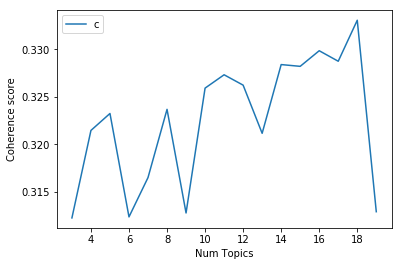

In [29]:
# Show graph
limit=20; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [30]:
#perplexity
def compute_perplexity_values(dictionary, corpus, texts, limit, start=3, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(lda_model10.log_perplexity(corpus))
        #lda_model10.log_perplexity(corpus)

    return model_list, coherence_values

In [31]:
# Perplexity as well is one of the intrinsic evaluation metric, and is widely used for language model evaluation.
# It captures how surprised a model is of new data it has not seen before, 
# and is measured as the normalized log-likelihood of a held-out test set.
#...lower is better

In [32]:
# Can take a long time to run.
model_list, coherence_values = compute_perplexity_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=3, limit=20, step=1)

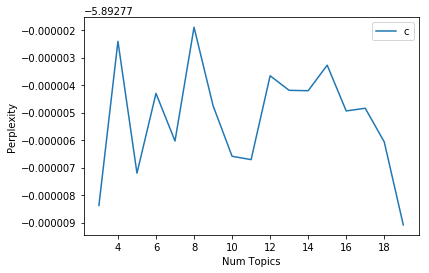

In [33]:
# Show graph
limit=20; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [34]:
#Log-liklihood
def compute_logliklihood_values(dictionary, corpus, texts, limit, start=3, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(model.best_score_)
        #lda_model10.log_perplexity(corpus)

    return model_list, coherence_values

In [35]:
# Focussing on the log-likelihood part, you can think of the perplexity metric as
# measuring how probable some new unseen data is given the modelthat was learned earlier.
# That is to say, how well does the model represent or reproduce the statistics of the held-out data.

In [ ]:
# Can take a long time to run.
#model_list, coherence_values = compute_logliklihood_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=3, limit=20, step=1)

In [ ]:
# Show graph
limit=20; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Log-likelihood")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
#8 Topics -----------------------------------------------------------

In [94]:
# Build LDA model
lda_model8 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=25,
                                           alpha='auto',
                                           per_word_topics=True)

In [95]:
# Print the Keyword in the 8 topics
pprint(lda_model8.print_topics())
doc_lda10 = lda_model8[corpus]

[(0,
  '0.050*"invest" + 0.041*"company" + 0.038*"real" + 0.036*"estate" + '
  '0.023*"stock" + 0.022*"industry" + 0.022*"investment" + 0.022*"asset" + '
  '0.019*"security" + 0.017*"condition"'),
 (1,
  '0.054*"company" + 0.023*"price" + 0.023*"value" + 0.019*"earning" + '
  '0.018*"stock" + 0.018*"growth" + 0.017*"market" + 0.016*"believe" + '
  '0.012*"fundamental" + 0.012*"valuation"'),
 (2,
  '0.089*"security" + 0.074*"fund" + 0.055*"investment" + 0.038*"invest" + '
  '0.026*"include" + 0.026*"risk" + 0.021*"foreign" + 0.017*"market" + '
  '0.017*"income" + 0.017*"asset"'),
 (3,
  '0.063*"commodity" + 0.037*"exposure" + 0.033*"fund" + 0.033*"instrument" + '
  '0.022*"contract" + 0.022*"derivative" + 0.021*"investment" + 0.020*"future" '
  '+ 0.018*"invest" + 0.016*"pimco"'),
 (4,
  '0.061*"fund" + 0.043*"index" + 0.020*"investment" + 0.019*"market" + '
  '0.016*"stock" + 0.014*"short" + 0.013*"portfolio" + 0.011*"return" + '
  '0.011*"long" + 0.011*"position"'),
 (5,
  '0.056*"fun

In [96]:
# Compute Perplexity
print('\nPerplexity: ', lda_model8.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model8, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

#Coherence Score:  0.41883900062637763 / Perplexity:  -5.901802396630192  -- 6 topics, 10 passes


Perplexity:  -5.842427408681363

Coherence Score:  0.43102019215668996


In [97]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model8, corpus, id2word)
vis

C:\Users\peter\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.095173 -0.041408       1        1  30.844084
4      0.023798 -0.143713       2        1  19.951033
6      0.124144 -0.111181       3        1  17.533049
1     -0.233027 -0.142630       4        1  10.098197
2      0.173990  0.102354       5        1   9.704971
0     -0.212393  0.231373       6        1   4.511095
7      0.022681  0.053315       7        1   4.124705
3      0.195979  0.051890       8        1   3.232865, topic_info=     Category          Freq            Term         Total  loglift  logprob
43    Default   5083.000000       portfolio   5083.000000  30.0000  30.0000
12    Default   8879.000000         company   8879.000000  29.0000  29.0000
50    Default  10373.000000        security  10373.000000  28.0000  28.0000
25    Default  22642.000000            fund  22642.000000  27.0000  27.0000
554   Default   3430.000000      allocation   3430.000000  26.0000  26.0000
2     Default   3330.000000         adviser   3330.000000  25.0000  25.0000
32    Default   8299.000000          invest   8299.000000  24.0000  24.0000
33    Default  10168.000000      investment  10168.000000  23.0000  23.0000
190   Default   5302.000000           stock   5302.000000  22.0000  22.0000
28    Default   4978.000000           index   4978.000000  21.0000  21.0000
435   Default   2930.000000        underlie   2930.000000  20.0000  20.0000
103   Default   1762.000000        exposure   1762.000000  19.0000  19.0000
544   Default   2385.000000          target   2385.000000  18.0000  18.0000
6     Default   7203.000000           asset   7203.000000  17.0000  17.0000
911   Default    864.000000       commodity    864.000000  16.0000  16.0000
10    Default   3080.000000  capitalization   3080.000000  15.0000  15.0000
121   Default   4065.000000         include   4065.000000  14.0000  14.0000
122   Default   2212.000000          income   2212.000000  13.0000  13.0000
126   Default   1258.000000      instrument   1258.000000  12.0000  12.0000
418   Default    732.000000             sub    732.000000  11.0000  11.0000
175   Default    957.000000            real    957.000000  10.0000  10.0000
24    Default   1738.000000         foreign   1738.000000   9.0000   9.0000
492   Default   1380.000000             fix   1380.000000   8.0000   8.0000
183   Default   2164.000000            risk   2164.000000   7.0000   7.0000
87    Default   1324.000000      derivative   1324.000000   6.0000   6.0000
99    Default    877.000000          estate    877.000000   5.0000   5.0000
35    Default   1421.000000           least   1421.000000   4.0000   4.0000
112   Default   2618.000000          growth   2618.000000   3.0000   3.0000
213   Default   1128.000000         earning   1128.000000   2.0000   2.0000
83    Default    974.000000        contract    974.000000   1.0000   1.0000
...       ...           ...             ...           ...      ...      ...
126    Topic8    399.460541      instrument   1258.464966   2.2843  -3.4209
103    Topic8    457.397797        exposure   1762.307739   2.0830  -3.2855
83     Topic8    274.216827        contract    974.635742   2.1637  -3.7971
882    Topic8     56.523956         dynamic    109.678802   2.7689  -5.3764
978    Topic8     45.689449          basket     79.812531   2.8740  -5.5892
87     Topic8    270.431732      derivative   1324.243530   1.8432  -3.8110
830    Topic8     63.018085          obtain    142.399658   2.6166  -5.2676
108    Topic8    244.716400          future   1390.216309   1.6947  -3.9109
1046   Topic8     56.353493            note    120.368347   2.6729  -5.3794
1733   Topic8     36.401936            roll     57.444416   2.9756  -5.8164
395    Topic8    104.515144          relate    408.009491   2.0698  -4.7617
492    Topic8    189.402328             fix   1380.925171   1.4452  -4.1671
431    Topic8    140.871796           total   1060.365845   1.4133  -4.46

In [101]:
p = pyLDAvis.gensim.prepare(lda_model8, corpus, id2word)
pyLDAvis.save_html(p, 'lda_8.html')

C:\Users\peter\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [ ]:
# Select the model and print the topics
optimal_model = lda_model8
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

In [59]:
sent_topics_df = pd.DataFrame(pd.DataFrame([sorted(topic[0], key=lambda x: (x[1]), reverse=True) for topic in lda_model8[corpus]])[0])
sent_topics_df.columns=["Data"]
sent_topics_df['Dominant_Topic'] = sent_topics_df.Data.apply(lambda x: x[0]+1)
sent_topics_df['Perc_Contribution'] = sent_topics_df.Data.apply(lambda x: round(x[1],4))
#sent_topics_df['Topic_Keywords'] = sent_topics_df.Dominant_Topic.apply(lambda x: top10dict[x])

In [67]:
df = pd.concat([df, sent_topics_df], axis=1)
df.head()
df.shape

(1800, 20)

In [68]:
#df.to_csv('Pass_NER_Topic.csv')

In [ ]:
#LDA15---------------------------------

In [102]:
# Build LDA model
lda_model15 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=25,
                                           alpha='auto',
                                           per_word_topics=True)

In [103]:
# Print the Keyword in the 15 topics
pprint(lda_model15.print_topics())
doc_lda10 = lda_model15[corpus]

[(0,
  '0.093*"real" + 0.088*"estate" + 0.066*"company" + 0.039*"invest" + '
  '0.033*"asset" + 0.026*"industry" + 0.023*"service" + 0.023*"investment" + '
  '0.021*"relate" + 0.020*"least"'),
 (1,
  '0.211*"option" + 0.084*"call" + 0.073*"put" + 0.063*"index" + 0.043*"write" '
  '+ 0.032*"purchase" + 0.032*"etf" + 0.025*"change" + 0.023*"price" + '
  '0.021*"sell"'),
 (2,
  '0.000*"diagnostic" + 0.000*"dental" + 0.000*"existence" + '
  '0.000*"uninvested" + 0.000*"pende" + 0.000*"optical" + 0.000*"hospital" + '
  '0.000*"sixty" + 0.000*"wider_margin" + 0.000*"deviations_fall"'),
 (3,
  '0.092*"commodity" + 0.066*"contract" + 0.065*"derivative" + '
  '0.063*"instrument" + 0.050*"exposure" + 0.048*"future" + 0.036*"currency" + '
  '0.027*"rate" + 0.025*"income" + 0.024*"fix"'),
 (4,
  '0.038*"fund" + 0.032*"market" + 0.031*"short" + 0.028*"position" + '
  '0.027*"stock" + 0.022*"security" + 0.020*"long" + 0.019*"portfolio" + '
  '0.019*"invest" + 0.016*"investment"'),
 (5,
  '0.079*"com

In [104]:
# Compute Perplexity
print('\nPerplexity: ', lda_model15.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model15, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

#Coherence Score:  0.41883900062637763 / Perplexity:  -5.901802396630192  -- 6 topics, 10 passes


Perplexity:  -6.428574257513678

Coherence Score:  0.4222446293348323


In [105]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model15, corpus, id2word)
vis

C:\Users\peter\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.163055 -0.099990       1        1  23.399765
10     0.145526  0.047917       2        1  19.134027
14     0.202114 -0.061219       3        1  15.683190
6      0.192243  0.058002       4        1  12.894222
4      0.146535 -0.023588       5        1   9.384001
12     0.138005  0.045062       6        1   5.740129
7      0.110986  0.035497       7        1   3.912398
8      0.115999 -0.135161       8        1   3.257711
3      0.064206  0.252761       9        1   2.623924
0      0.036871 -0.216119      10        1   2.393827
1     -0.145559  0.270970      11        1   0.764263
11    -0.268102 -0.040563      12        1   0.423183
13    -0.283605 -0.056940      13        1   0.387052
9     -0.309137 -0.038314      14        1   0.001152
2     -0.309137 -0.038314      15        1   0.001146, topic_info=     Category          Freq                 Term         Total  loglift  \
28    Default   5199.000000                index   5199.000000  30.0000   
12    Default   9315.000000              company   9315.000000  29.0000   
43    Default   5685.000000            portfolio   5685.000000  28.0000   
2     Default   3371.000000              adviser   3371.000000  27.0000   
554   Default   3607.000000           allocation   3607.000000  26.0000   
25    Default  23584.000000                 fund  23584.000000  25.0000   
461   Default   1120.000000               option   1120.000000  24.0000   
50    Default  10776.000000             security  10776.000000  23.0000   
183   Default   2265.000000                 risk   2265.000000  22.0000   
440   Default   3168.000000                value   3168.000000  21.0000   
103   Default   1874.000000             exposure   1874.000000  20.0000   
33    Default  10498.000000           investment  10498.000000  19.0000   
544   Default   2508.000000               target   2508.000000  18.0000   
435   Default   3065.000000             underlie   3065.000000  17.0000   
190   Default   5614.000000                stock   5614.000000  16.0000   
87    Default   1383.000000           derivative   1383.000000  15.0000   
126   Default   1330.000000           instrument   1330.000000  14.0000   
351   Default   1197.000000           management   1197.000000  13.0000   
6     Default   7529.000000                asset   7529.000000  12.0000   
911   Default    987.000000            commodity    987.000000  11.0000   
175   Default   1011.000000                 real   1011.000000  10.0000   
225   Default   1860.000000                price   1860.000000   9.0000   
22    Default   5123.000000               equity   5123.000000   8.0000   
99    Default    920.000000               estate    920.000000   7.0000   
32    Default   8638.000000               invest   8638.000000   6.0000   
47    Default   1450.000000             purchase   1450.000000   5.0000   
108   Default   1463.000000               future   1463.000000   4.0000   
122   Default   2316.000000               income   2316.000000   3.0000   
83    Default   1034.000000             contract   1034.000000   2.0000   
11    Default   1913.000000               change   1913.000000   1.0000   
...       ...           ...                  ...           ...      ...   
4266  Topic15      0.001015                  fad      0.842900   4.6551   
1417  Topic15      0.001015     monetary_policie      6.758579   2.5733   
1431  Topic15      0.001015             choosing      4.691894   2.9383   
1430  Topic15      0.001015              usually     44.392365   0.6911   
1429  Topic15      0.001015           tremendous      0.842799   4.6552   
1428  Topic15      0.001015               travel      6.286451   2.6458   
1427  Topic15      0.001015            timeframe      0.843209   4.6547   
1426  Topic15      0.001015      tacit_knowledge      6.286451   2.6458   
1425  Topic15      0.001015            

In [107]:
p = pyLDAvis.gensim.prepare(lda_model15, corpus, id2word)
pyLDAvis.save_html(p, 'lda_15.html')

C:\Users\peter\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [55]:
# Select the model and print the topics
optimal_model = lda_model15
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.093*"real" + 0.088*"estate" + 0.066*"company" + 0.039*"invest" + '
  '0.033*"asset" + 0.026*"industry" + 0.023*"service" + 0.023*"investment" + '
  '0.021*"relate" + 0.020*"least"'),
 (1,
  '0.211*"option" + 0.084*"call" + 0.073*"put" + 0.063*"index" + 0.043*"write" '
  '+ 0.032*"purchase" + 0.032*"etf" + 0.025*"change" + 0.023*"price" + '
  '0.021*"sell"'),
 (2,
  '0.000*"diagnostic" + 0.000*"dental" + 0.000*"existence" + '
  '0.000*"uninvested" + 0.000*"pende" + 0.000*"optical" + 0.000*"hospital" + '
  '0.000*"sixty" + 0.000*"wider_margin" + 0.000*"deviations_fall"'),
 (3,
  '0.092*"commodity" + 0.066*"contract" + 0.065*"derivative" + '
  '0.063*"instrument" + 0.050*"exposure" + 0.048*"future" + 0.036*"currency" + '
  '0.027*"rate" + 0.025*"income" + 0.024*"fix"'),
 (4,
  '0.038*"fund" + 0.032*"market" + 0.031*"short" + 0.028*"position" + '
  '0.027*"stock" + 0.022*"security" + 0.020*"long" + 0.019*"portfolio" + '
  '0.019*"invest" + 0.016*"investment"'),
 (5,
  '0.079*"com

,Unnamed: 0,Unnamed: 0.1,accession#,filing_year,principal_strategies,Fog_avg,Fog_dist,Ari_avg,Ari_dist,Sent_count_avg,Pass_verb_avg,Pass_sent_avg,Pass_verb_dist,Pass_sent_dist
0,0,1179,0001209286-10-000410,2010,the fund invests at least 80% of its assets in...,18,"[19.71, 14.8, 11.31, 16.91, 10.3, 18.13, 8.2, ...",14,"[13.5, 11.7, 8.1, 17.3, 11.5, 14.6, 6.1, 22.3,...",10,0.183333,0.020000,"[0.0, 0.0, 0.3333333333333333, 0.0, 0.5, 0.0, ...","[0.0, 0.0, 0.1, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, ..."
1,1,439,0000950123-10-063295,2010,"to pursue its goal, the fund primarily invests...",17,"[16.02, 24.13, 19.88, 16.67, 16.55, 20.0, 20.2...",15,"[11.9, 24.1, 16.3, 11.5, 16.8, 20.7, 30.0, 9.3...",29,0.092241,0.013080,"[0.0, 0.0, 0.4, 0.0, 0.0, 0.1, 0.0, 0.4, 0.0, ...","[0.0, 0.0, 0.06896551724137931, 0.0, 0.0, 0.03..."
2,2,735,0000898432-10-001255,2010,"| during normal market conditions, the large c...",22,"[29.75, 20.0, 18.0, 28.27, 22.0, 18.9]",22,"[30.0, 20.7, 17.4, 30.8, 23.5, 13.7]",6,0.055556,0.055556,"[0.0, 0.16666666666666666, 0.0, 0.0, 0.1666666...","[0.0, 0.16666666666666666, 0.0, 0.0, 0.1666666..."
3,3,489,0001104659-10-022919,2010,"under normal market conditions, the portfolio ...",19,"[20.86, 16.02, 16.09, 32.18, 21.07, 17.8, 16.6...",19,"[22.7, 12.4, 14.5, 34.5, 24.5, 21.1, 15.3, 24....",49,0.124927,0.012911,"[0.0, 0.0, 0.3333333333333333, 0.2857142857142...","[0.0, 0.0, 0.02040816326530612, 0.040816326530..."
4,4,233,0001193125-10-081545,2010,"under normal circumstances, the fund invests a...",17,"[21.26, 24.25, 14.11, 15.02, 16.55, 20.86, 18....",16,"[19.9, 23.6, 12.9, 16.9, 16.9, 23.0, 13.3, 11....",9,0.185185,0.061728,"[0.0, 0.16666666666666666, 0.5, 0.0, 0.0, 0.0,...","[0.0, 0.1111111111111111, 0.1111111111111111, ..."


In [122]:
# Create Document - Topic Matrix
lda_output = lda_model4.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_topics)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

AttributeError: 'LdaModel' object has no attribute 'transform'

In [118]:
def format_topics_sentences(ldamodel=lda_model4, corpus=corpus, texts=id2word):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model4, corpus=corpus, texts=id2word)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

TypeError: '<' not supported between instances of 'int' and 'tuple'

In [ ]:
df_dominant_topic.to_csv('LDA_4.csv')

In [ ]:
#LDA 12 Topics

In [ ]:
# Build LDA model
lda_model12 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=12, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=25,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model12.print_topics())
doc_lda10 = lda_model12[corpus]

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model12.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model12, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

#Coherence Score:  0.4249947108716034  -- 10 topics, 10 passes

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model12, corpus, id2word)
vis

In [ ]:
#LDA Models ------------------

In [ ]:
# # Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# mallet_path = 'C:\\Users\peter\Desktop\MSA_Fall19\Image&Text\Proj_2_Topics\mallet-2.0.8\mallet-2.0.8\bin\mallet.bat' # update this path
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [ ]:
#Model Tuning ------------------------------------------------------------------

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=3, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# # Build LDA model
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=10, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha='auto',
#                                            per_word_topics=True)

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=3, limit=20, step=1)

In [ ]:
# Show graph
limit=20; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
#Review Results ------------------------------------------------------------------

In [ ]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

In [119]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet = sent_topics_sorteddf_mallet.dropna(subset=['Topic_Num'])
#sent_topics_sorteddf_mallet
sent_topics_sorteddf_mallet

NameError: name 'df_topic_sents_keywords' is not defined

In [120]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

df_dominant_topics = df_dominant_topics.dropna(subset=['Num_Documents'])

df_dominant_topics

NameError: name 'df_topic_sents_keywords' is not defined

In [ ]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

In [121]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

NameError: name 'df_topic_sents_keywords' is not defined